In [1]:
from pycirclize import Circos
import pandas as pd
import numpy as np
import os
from matplotlib.patches import Patch

In [5]:
# 设置工作目录
print(os.getcwd())
os.chdir("/home/gyk/project/lw")

# 基因密度数据
bed_file = "/home/gyk/reference/genome/Bomo_genome_assembly.chrom.bed"
gene_density = pd.read_table("/home/gyk/reference/genome/Bomo_gene_density.txt")

circos = Circos.initialize_from_bed(bed_file, space=2)
circos.text("Bombyx mori", size=12, r=20)

# RNAseq数据
# 读取基因丰度文件
gene_exp_df = pd.read_table("/home/gyk/project/lw_rna_nf/results/star_salmon/stringtie/DZ.gene.abundance.txt", header= 0)


# 对表达数据取对数转换
# gene_exp_df['mean'] = np.log10(gene_exp_df['mean'] + 1)

# atac peaks
peaks = pd.read_table("/home/gyk/project/lw_atac_nf/results/bwa/merged_replicate/macs2/narrow_peak/DZ.mRp.clN_peaks.xls", comment = "#", header = 0)

# compartment
compartment = pd.read_table("/home/gyk/project/lw_hic_snHiC/10_Compartments_detection_dcHiC/20kb_resolution/DifferentialResult/all_vs_all/viz/files_compartment_beds/intra_DZ_mapQ15_20kb_PC_compartments_sorted.bed",
                            header = None, skiprows = 1)
compartment = compartment[[0, 1, 2, 3]]
compartment.columns = ['chr', 'start', 'end', 'compartment']


/home/gyk/project/lw


In [7]:
# 绘图
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=8)
    # Outer Track
    outer_track = sector.add_track((100, 100))
    outer_track.axis()
    outer_track.xticks_by_interval(
        5000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb",
    )
    # gene density
    gene_density_track = sector.add_track((95, 100))
    gene_density_track.axis(fc="none", ec="none", lw=0)
    for t in gene_density[gene_density['chr'] == sector.name].itertuples(index=False):
        start = t.start
        end = t.end
        if t.type == 'gene':
            gene_density_track.rect(start, end, color='blue', alpha=0.5)
        else:
            gene_density_track.rect(start, end, color="lightgrey", alpha=0.5)

    # rna-seq
    exp_track = sector.add_track((85, 95))
    exp_track.axis(fc="none", ec="none", lw=0)
    gene_exp_df_sector = gene_exp_df[gene_exp_df['Reference'] == sector.name]
    exp_track.bar(gene_exp_df_sector["Start"], gene_exp_df_sector["TPM"], width = gene_exp_df_sector["End"] - gene_exp_df_sector["Start"], color = 'purple')

    # atac-seq
    atac_track = sector.add_track((75,85))
    atac_track.axis(fc="none", ec="none", lw=0)
    atac_sector = peaks[peaks["chr"] == sector.name]
    atac_track.bar(atac_sector["start"], atac_sector["pileup"], width = atac_sector["length"], color = 'red')

    #compartment
    compartment_track = sector.add_track((65,75))
    compartment_track.axis(fc="none", ec="none", lw=0)
    compartment_sector = compartment[compartment["chr"] == sector.name]
    for row in compartment_sector.itertuples():
        if row.compartment == "A":
            compartment_track.rect(row.start, row.end, color = 'salmon')
        else:
            compartment_track.rect(row.start, row.end, color = 'skyblue')

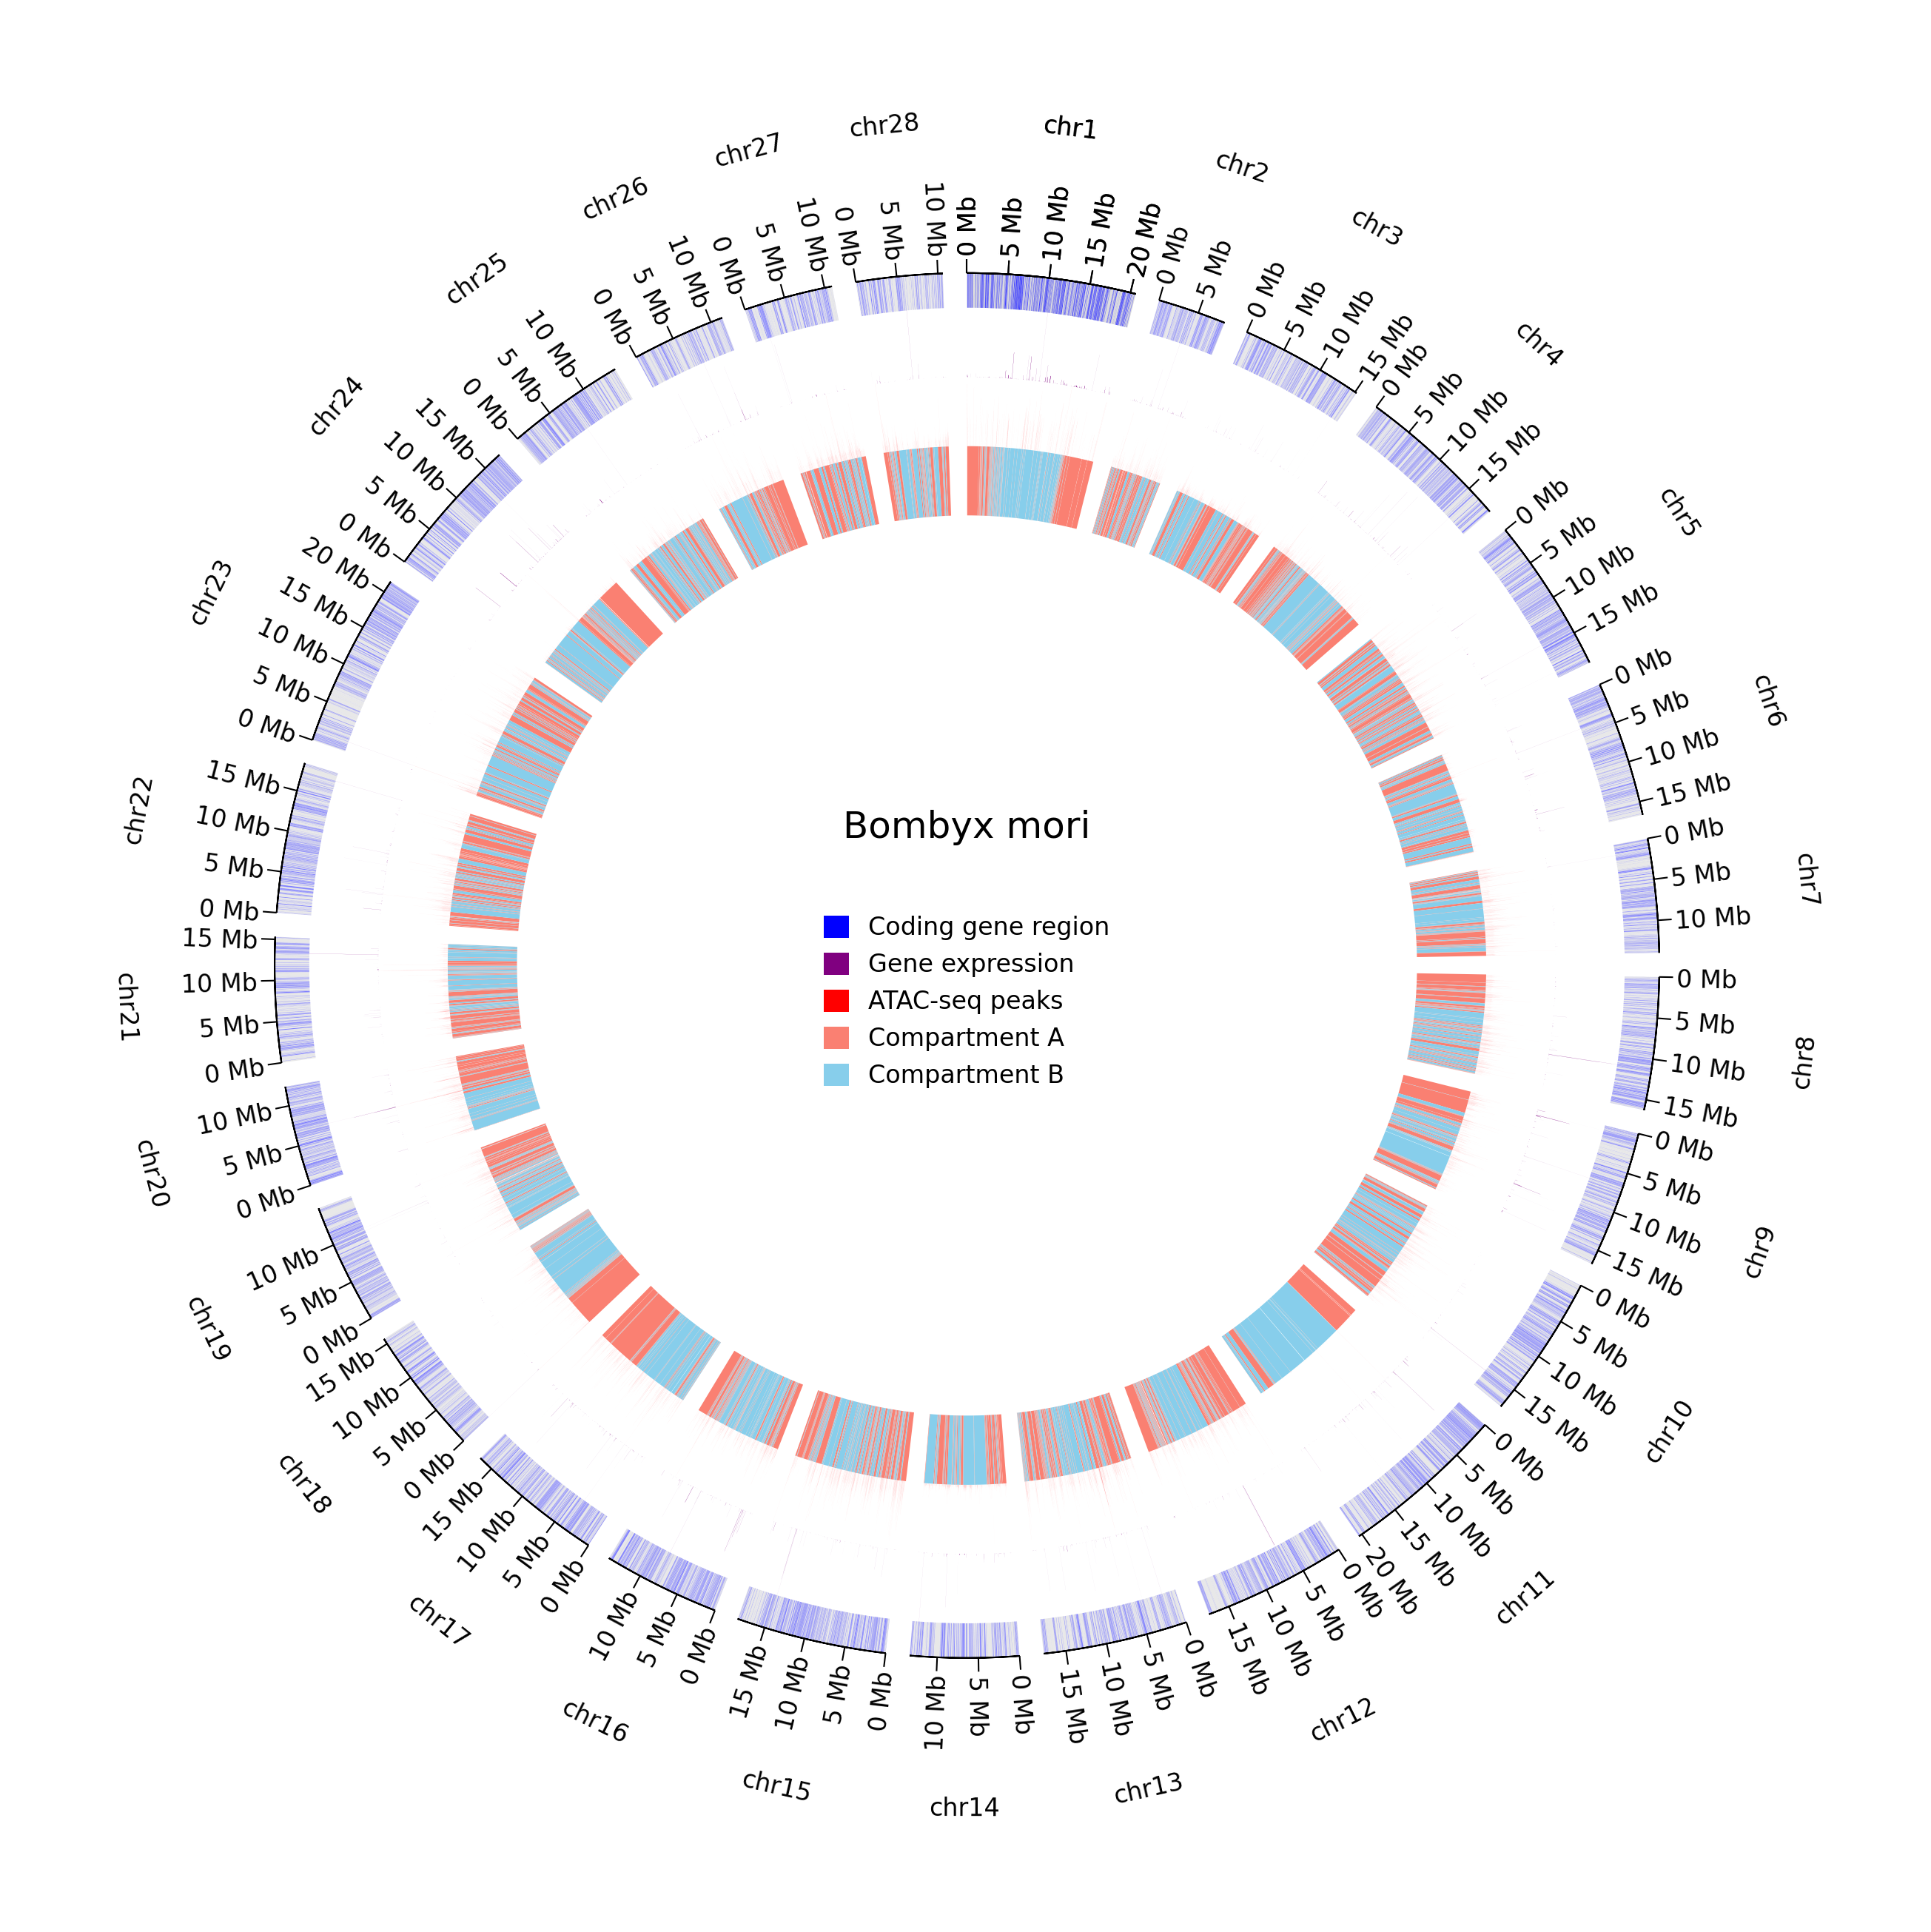

In [12]:
# Add legend
handles = [
    Patch(color="blue", label="Coding gene region"),
    Patch(color="purple", label="Gene expression"),
    Patch(color="red", label="ATAC-seq peaks"),
    Patch(color="salmon", label="Compartment A"),
    Patch(color="skyblue", label="Compartment B")
]
fig = circos.plotfig(dpi=300)
_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=8)
fig.savefig("fig1a.png", dpi=300)